In [75]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import linear_model, svm, tree, neighbors, ensemble
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.grid_search import GridSearchCV
from time import time
import xgboost as xgb
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

In [76]:
"""警告の非表示"""
import warnings
warnings.filterwarnings('ignore')

In [77]:
%precision 3
%matplotlib inline

In [78]:
os.chdir('D:/LocalData/N196003/Desktop/UNS/2017 US UNS SPSS-sav')

In [79]:
NG = [0 for i in range(14)]

In [80]:
for i in range(1, 14):
    NG[i] = pd.read_csv('NG_ ' + str(i) + '_.csv')
    NG[i] = NG[i].drop('Unnamed: 0', axis=1)

In [81]:
X_original = NG[1].drop('1', axis=1)
Y_original = NG[1]['1']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_original, Y_original, test_size = 0.3, random_state = 0)

In [83]:
negative_count_train = y_train[y_train == 0].count()
positive_count_train = y_train[y_train == 1].count()

In [84]:
def Resampled_Valudation(X_train, y_train, n_splits):
    
    matrix = []
    PRE = []
    REC = []
    F1 = []
    ROC_AUC = []
    k = 1
    
    flod = KFold(n_splits=n_splits, random_state=1)
    r = 0.5
    
    for train_index, test_index in flod.split(X_train, y_train):
        x_ta = X_train.values[train_index]
        x_te = X_train.values[test_index]
        y_ta = y_train.values[train_index]
        y_te = y_train.values[test_index]
        
        negative_count = len(y_ta) - y_ta.sum()
        positive_count = y_ta.sum()

        smt = RandomUnderSampler(ratio={0: positive_count, 1: positive_count})
        #smt =SMOTE(ratio='auto', n_jobs=-1)
        x_ta_resampled, y_ta_resampled = smt.fit_sample(x_ta, y_ta)

        sts = StandardScaler()
        clf = xgb.XGBClassifier()
        pipe = make_pipeline(sts, clf)

        pipe.fit(x_ta_resampled, y_ta_resampled)
        y_pred = pipe.predict(x_te)

        matrix.append(confusion_matrix(y_te, y_pred))
        PRE.append(precision_score(y_te, y_pred))
        REC.append(recall_score(y_te, y_pred))
        F1.append(f1_score(y_te, y_pred))
        ROC_AUC.append(roc_auc_score(y_te, y_pred))
        
        print ("Done: %d, Totaling: %d" % (k, n_splits))
        k += 1
        
    return matrix, np.array(PRE), np.array(REC), np.array(F1), np.array(ROC_AUC)

In [86]:
Matrix, PRE, REC, F1, ROC_AUC = Resampled_Valudation(X_train, y_train, 5)

Done: 1, Totaling: 5
Done: 2, Totaling: 5
Done: 3, Totaling: 5
Done: 4, Totaling: 5
Done: 5, Totaling: 5


In [87]:
PRE.mean(), REC.mean(), ROC_AUC.mean()

(0.328, 0.879, 0.847)

In [88]:
Matrix[3]

array([[2108,  443],
       [  33,  228]], dtype=int64)

In [89]:
def get_importance_score(X, IM_score):
    Questions = pd.DataFrame(X.columns)
    importance = pd.DataFrame(IM_score)
    Score = pd.concat([Questions, importance], axis=1)
    Score.columns = ['Var', 'Score']
    return Score

In [90]:
def Resampled_Valudation_Score(X_train, y_train, n_splits, verbose=False):
    
    ROC_AUC = []
    F1 = []
    Importance_Score = []
    k = 1
    
    flod = KFold(n_splits=n_splits, random_state=1)
    r = 0.5
    
    for train_index, test_index in flod.split(X_train, y_train):
        x_ta = X_train.values[train_index]
        x_te = X_train.values[test_index]
        y_ta = y_train.values[train_index]
        y_te = y_train.values[test_index]
        
        negative_count = len(y_ta) - y_ta.sum()
        positive_count = y_ta.sum()

        smt = RandomUnderSampler(ratio={0: positive_count, 1: positive_count})
        #smt =SMOTE(ratio='auto', n_jobs=-1)
        x_ta_resampled, y_ta_resampled = smt.fit_sample(x_ta, y_ta)

        sts = StandardScaler()
        clf = xgb.XGBClassifier(n_jobs=-1)
        
        sts.fit(x_ta_resampled)
        x_ta_resampled = sts.transform(x_ta_resampled)
        x_te = sts.transform(x_te)
        
        clf.fit(x_ta_resampled, y_ta_resampled)
        y_pred = clf.predict(x_te)

        ROC_AUC.append(roc_auc_score(y_te, y_pred))
        F1.append(f1_score(y_te, y_pred))
        Importance_Score.append(clf.feature_importances_)
        
        if verbose == True:
            print ("Done: %d, Totaling: %d" % (k, n_splits))
        else:
            pass
        
        k += 1
        
    return np.array(ROC_AUC), np.array(F1), get_importance_score(X_train, sum(Importance_Score) / n_splits)

In [91]:
def Resampled_RFECV(X, y, n_steps, cv, verbose=False):
    if 100 % n_steps != 0:
        print("Error: n_steps must be a divisior of 100")
        return 1
    else:
        ROC_SCORE_mean = []
        F1_SCORE_mean = []
        Questions = []
        
        step = np.arange(n_steps, 100+n_steps, n_steps)[::-1]
        for i in tqdm(range(len(step))):
            
            if verbose == True:
                print("Fitting: %d features" % step[i])
            else:
                pass
            
            ROC_SCORE, F1_SCORE, IM_score = Resampled_Valudation_Score(X, y, cv)
            IM_new = IM_score.sort_values(by='Score').reset_index(drop=True).drop(range(n_steps))
            ROC_SCORE_mean.append(ROC_SCORE.mean())
            F1_SCORE_mean.append(F1_SCORE.mean())
            X = X.loc[:, IM_new.Var]
            Questions.append(IM_new)
            
        return np.array(ROC_SCORE_mean[::-1]), np.array(F1_SCORE_mean[::-1]), Questions[::-1]

In [92]:
ROC_AUC_mean, F1_SCORE_mean, Selected_Q = Resampled_RFECV(X_train, y_train, n_steps=1, cv=5, verbose=False)



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:04<06:57,  4.22s/it]

  2%|▏         | 2/100 [00:08<06:47,  4.16s/it]

  3%|▎         | 3/100 [00:12<06:44,  4.17s/it]

  4%|▍         | 4/100 [00:16<06:37,  4.14s/it]

  5%|▌         | 5/100 [00:20<06:32,  4.13s/it]

  6%|▌         | 6/100 [00:24<06:24,  4.09s/it]

  7%|▋         | 7/100 [00:28<06:18,  4.07s/it]

  8%|▊         | 8/100 [00:33<06:20,  4.14s/it]

  9%|▉         | 9/100 [00:37<06:18,  4.15s/it]

 10%|█         | 10/100 [00:41<06:13,  4.15s/it]

 11%|█         | 11/100 [00:45<06:05,  4.11s/it]

 12%|█▏        | 12/100 [00:48<05:58,  4.08s/it]

 13%|█▎        | 13/100 [00:52<05:53,  4.07s/it]

 14%|█▍        | 14/100 [00:56<05:46,  4.03s/it]

 15%|█▌        | 15/100 [01:00<05:40,  4.00s/it]

 16%|█▌        | 16/100 [01:03<05:33,  3.97s/it]

 17%|█▋        | 17/100 [01:07<05:27,  3.95s/it]

 18%|█▊        | 18/100 [01:10<05:22,  3.94s/it]

 19%|█▉        | 19/100 [01:14<05:17,  3.92s/it]

 20%|██        |

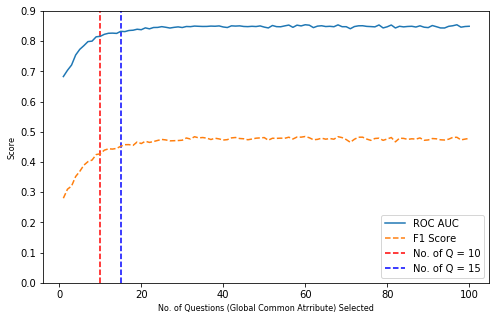

In [93]:
"""設問数と精度の関係を描画"""
plt.clf()
fig = plt.figure(figsize=(8,5), facecolor='w')
plt.plot(np.arange(1, 101, 1), ROC_AUC_mean, '-', label='ROC AUC')
plt.plot(np.arange(1, 101, 1), F1_SCORE_mean, '--', label='F1 Score')
plt.vlines(10, 0.0, 0.9, 'red', linestyles='dashed', label ='No. of Q = 10')
plt.vlines(15, 0.0, 0.9, 'blue', linestyles='dashed', label ='No. of Q = 15')
plt.xlabel('No. of Questions (Global Common Atrribute) Selected', fontsize = 8)
plt.ylabel('Score', fontsize = 8)
plt.ylim(0, 0.9)
plt.legend(loc='lower right')
plt.show()

In [100]:
Selected_Q[10]

,Var,Score
1,Q2_25,0.071044
2,Q5_58,0.071821
3,Q5_22,0.089347
4,Q2_6,0.091948
5,Q5_1,0.092371
6,Q5_14,0.092550
7,Q2_16,0.093951
8,Q2_30,0.105658
9,Q5_39,0.110561
10,Q5_50,0.110896


In [48]:
def BalancedBagging_Valudation(X_train, y_train, n_splits):
    
    matrix = []
    PRE = []
    REC = []
    F1 = []
    ROC_AUC = []
    k = 1
    
    flod = KFold(n_splits=n_splits, random_state=71)
    
    for train_index, test_index in flod.split(X_train, y_train):
        x_ta = X_train.values[train_index]
        x_te = X_train.values[test_index]
        y_ta = y_train.values[train_index]
        y_te = y_train.values[test_index]
        
        negative_count = len(y_ta) - y_ta.sum()
        positive_count = y_ta.sum()

        sts = StandardScaler()
        clf = xgb.XGBClassifier(n_jobs=-1)
        usbc = BalancedBaggingClassifier(base_estimator=clf, n_jobs=-1, n_estimators=10, ratio='not minority')
        pipe = make_pipeline(sts, usbc)

        pipe.fit(x_ta, y_ta)
        y_pred = pipe.predict(x_te)

        matrix.append(confusion_matrix(y_te, y_pred))
        PRE.append(precision_score(y_te, y_pred))
        REC.append(recall_score(y_te, y_pred))
        F1.append(f1_score(y_te, y_pred))
        ROC_AUC.append(roc_auc_score(y_te, y_pred))
        
        print ("Done: %d, Totaling: %d" % (k, n_splits))
        k += 1
        
    return matrix, np.array(PRE), np.array(REC), np.array(F1), np.array(ROC_AUC)

In [49]:
Matrix, PRE, REC, F1, ROC_AUC = BalancedBagging_Valudation(X_train, y_train, 10)

Done: 1, Totaling: 10
Done: 2, Totaling: 10
Done: 3, Totaling: 10
Done: 4, Totaling: 10
Done: 5, Totaling: 10
Done: 6, Totaling: 10
Done: 7, Totaling: 10
Done: 8, Totaling: 10
Done: 9, Totaling: 10
Done: 10, Totaling: 10


In [50]:
PRE.mean(), REC.mean(), ROC_AUC.mean(), F1.mean()

(0.353, 0.873, 0.855, 0.503)

In [52]:
Matrix[9]

array([[1061,  208],
       [  18,  119]], dtype=int64)

In [89]:
"""すべてのNGに対してRFECV法を利用し、設問数と予測精度の関係を見る"""
def RFECV_for_NG(X_train, y_train, step):
    """アルゴリズムの初期化とデータの標準化"""
    clf_xgb = make_pipeline(StandardScaler(), xgb.XGBClassifier(random_state=0))
    
    """層化k分割交差検証を呼び出し"""
    kflod = StratifiedKFold(n_splits=5, random_state=1).split(X_train, y_train)
    
    """説明力が小さい設問から5問ずつ落としていき、精度を見る"""
    selector_cv = RFECV(clf_xgb, step=step, cv=kflod, scoring='f1', n_jobs=-1)
    start = time()
    selector_cv.fit(X_train, y_train)
    print("Time: {} s".format(time() - start))
    
    grid_score = selector_cv.grid_scores_
        
    return grid_score

In [90]:
X_train_resampled, y_train_resampled = Resample_train(X_train, y_train)

precision : 0.974
recall : 0.903
f1 score; 0.924


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.9s finished


In [45]:
grid_score = RFECV_for_NG(X_train_resampled, y_train_resampled, step=5)

Time: 564.9348170757294 s


In [50]:
grid_score.

21

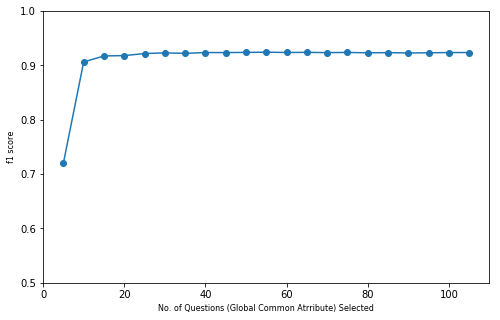

In [51]:
"""設問数と精度の関係を描画"""
plt.clf()
fig = plt.figure(figsize=(8,5), facecolor='w')
plt.plot(np.arange(5, 110, 5), grid_score, 'o-')
plt.xlabel('No. of Questions (Global Common Atrribute) Selected', fontsize = 8)
plt.ylabel('f1 score', fontsize = 8)
plt.ylim(0.5, 1.0)
plt.show()

In [43]:
def RFE_for_NG(X_train, Y_train):
    
    """データの標準化"""
    scaler = StandardScaler()
    scaler.fit(X_train)
    x_train = scaler.transform(X_train)
    
    """説明力が小さい設問から5問ずつ落としていき、精度を見る"""
    selector = RFE(xgb.XGBClassifier(), n_features_to_select =10, step=5, verbose=1)
    start = time()
    selector.fit(x_train, Y_train)
    print("Time: {} s".format(time() - start))
    
    x_selected = selector.transform(x_train)
    support = selector.get_support()
        
    return x_selected, support

In [44]:
x_selected, support = RFE_for_NG(X_train_resampled, Y_train_resampled)

Fitting estimator with 100 features.
Fitting estimator with 95 features.
Fitting estimator with 90 features.
Fitting estimator with 85 features.
Fitting estimator with 80 features.
Fitting estimator with 75 features.
Fitting estimator with 70 features.
Fitting estimator with 65 features.
Fitting estimator with 60 features.
Fitting estimator with 55 features.
Fitting estimator with 50 features.
Fitting estimator with 45 features.
Fitting estimator with 40 features.
Fitting estimator with 35 features.
Fitting estimator with 30 features.
Fitting estimator with 25 features.
Fitting estimator with 20 features.
Fitting estimator with 15 features.
Time: 249.13481450080872 s


In [45]:
x1_selected, x2_selected, y1_selected, y2_selected = train_test_split(x_selected, Y_train_resampled, test_size = 0.3)
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(x1_selected, y1_selected)
tn, fp, fn, tp = confusion_matrix(y2_selected, clf_xgb.predict(x2_selected)).ravel()

PRE = tp / (tp + fp)
REC = tp / (tp + fn)
f1 = 2 * PRE *REC / (PRE + REC)

print('precision : %.3f'% PRE)
print('recall : %.3f'% REC)
print('f1 score; %.3f' % f1)

precision : 0.960
recall : 0.935
f1 score; 0.948


In [46]:
selected_q = pd.concat([pd.Series(X_train.columns), pd.Series(support)], axis=1)
selected_q.columns = ['Question', 'Selected or Not']
selected_q.to_csv('Selected_Q_TF_NG1.csv')

In [47]:
selected_q[selected_q['Selected or Not'] == True]

,Question,Selected or Not
38,Q2_6,True
41,Q2_9,True
46,Q2_16,True
55,Q2_30,True
56,Q5_1,True
59,Q5_6,True
70,Q5_24,True
81,Q5_39,True
88,Q5_50,True
91,Q5_53,True


In [42]:
Questions = pd.DataFrame(NG[1].columns)
importance = pd.DataFrame(clf_xgb.feature_importances_)
Importance_score = pd.concat([Questions, importance], axis=1)
Importance_score.columns = ['Variables', 'Score']

No handles with labels found to put in legend.


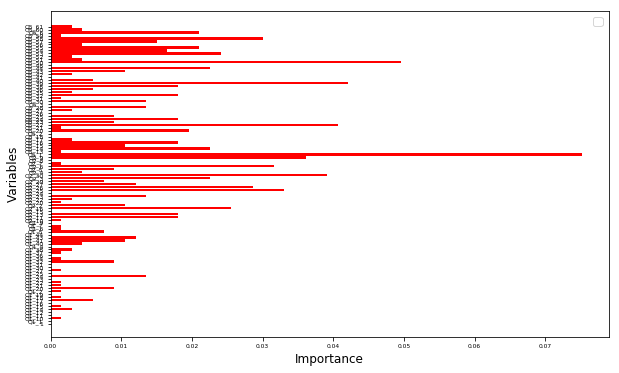

In [43]:
plt.clf()
fig = plt.figure(figsize=(10,6), facecolor='w')
plt.barh(Importance_score.Variables, Importance_score.Score, color = 'red')

plt.xlabel('Importance', fontsize = 12)
plt.ylabel('Variables', fontsize = 12)
plt.legend(loc='best', fontsize = 12)
plt.tick_params(labelsize=6)
plt.show()